# Chapter 4: Splines

**From Statistical Rethinking by Richard McElreath**

This notebook covers **splines** - a powerful alternative to polynomial regression for modeling curved relationships.

## What We'll Learn

1. **Problems with polynomials** - why high-degree polynomials are dangerous
2. **B-splines basics** - building smooth curves from basis functions
3. **Knot placement** - choosing where curves can change shape
4. **Model fitting** - using spline basis functions as predictors
5. **Advantages** - why splines are better than polynomials

## The Problem with Polynomials

Polynomial regression has serious limitations:
- **Global influence**: Changing one part affects the entire curve
- **Poor extrapolation**: Extreme predictions outside data range
- **Numerical instability**: High-degree terms (x⁵, x⁶) cause problems
- **Overfitting**: Wiggly curves that fit noise

## The Solution: Splines

**Splines** are smooth curves built from **piecewise polynomials**:
- Divide x-axis into regions using **knots**
- Fit low-degree polynomial in each region
- Smooth connections at knots
- **Local influence**: Changes in one region don't affect distant regions

## B-splines (Basis Splines)

**B-splines** are a clever way to construct splines:
- Create **basis functions** (Bᵢ(x))
- Each basis function is "bump-shaped" and local
- Final curve is weighted sum: f(x) = Σ wᵢ·Bᵢ(x)
- Weights (wᵢ) are the parameters we estimate

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.interpolate import BSpline
import sys
from pathlib import Path

# Import our quap implementation
sys.path.append(str(Path.cwd().parent))
from src.quap import quap, QuapResult

# Set random seed
np.random.seed(42)
rng = np.random.default_rng(42)

plt.style.use('default')
%matplotlib inline

print('✓ Imports loaded')

✓ Imports loaded


---

## Step 1: Load the Data

We'll continue using the **Howell1** dataset - height vs weight relationship.

In [2]:
# Load Howell dataset
url = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/Howell1.csv"
howell = pd.read_csv(url, sep=";")  # Note: sep=";" because it's semicolon-separated

# Filter for adults only
adult_data = howell[howell['age'] >= 18].copy()

# Extract variables
height = adult_data['height'].values
weight = adult_data['weight'].values

print(f"Dataset: {len(adult_data)} adults")
print(f"Height range: [{height.min():.1f}, {height.max():.1f}] cm")
print(f"Weight range: [{weight.min():.1f}, {weight.max():.1f}] kg")

Dataset: 352 adults
Height range: [136.5, 179.1] cm
Weight range: [31.1, 63.0] kg


## Step 2: Understanding B-spline Basis Functions

### What are Basis Functions?

Think of basis functions as **building blocks**:
- Each basis function Bᵢ(x) is a smooth "bump" centered at different locations
- They have **local support** - non-zero only in a small region
- We combine them with weights: f(x) = w₁·B₁(x) + w₂·B₂(x) + w₃·B₃(x) + ...

### Key Parameters

1. **Degree** (usually 3 for cubic splines)
   - Controls smoothness of basis functions
   - Degree 3 = cubic = second derivative continuous

2. **Knots** - points where basis functions connect
   - More knots = more flexibility
   - Fewer knots = smoother, less wiggly
   - **Common choice**: Quantiles of the data

### Visualizing Basis Functions

Let's create and visualize B-spline basis functions.

In [3]:
def create_bspline_basis(x, num_knots=5, degree=3, interior_knots=None):
    """
    Create B-spline basis matrix.
    
    Parameters:
    -----------
    x : array
        Input values (must be sorted or will be sorted)
    num_knots : int
        Number of interior knots (only used if interior_knots is None)
    degree : int
        Degree of B-spline (3 = cubic)
    interior_knots : array, optional
        Specific knot locations. If None, uses quantiles.
    
    Returns:
    --------
    B : array of shape (len(x), num_basis_functions)
        Basis matrix where each column is a basis function
    knots_all : array
        All knots (including boundary knots)
    """
    x_min, x_max = x.min(), x.max()
    
    # Define interior knots
    if interior_knots is None:
        # Use quantiles to place knots
        knot_positions = np.linspace(0, 1, num_knots + 2)[1:-1]  # Exclude 0 and 1
        interior_knots = np.quantile(x, knot_positions)
    
    # Create full knot vector (with repeated boundary knots)
    # For degree d, we need d+1 repeated knots at each boundary
    boundary_knots = np.array([x_min, x_max])
    knots_all = np.concatenate([
        np.repeat(boundary_knots[0], degree + 1),
        interior_knots,
        np.repeat(boundary_knots[1], degree + 1)
    ])
    
    # Number of basis functions = number of knots - degree - 1
    num_basis = len(knots_all) - degree - 1
    
    # Create basis matrix
    B = np.zeros((len(x), num_basis))
    
    for i in range(num_basis):
        # Create B-spline basis function i
        # Coefficients: all zeros except position i
        coef = np.zeros(num_basis)
        coef[i] = 1.0
        
        # Evaluate basis function at all x values
        bspline = BSpline(knots_all, coef, degree)
        B[:, i] = bspline(x)
    
    return B, interior_knots

print("✓ B-spline basis creation function defined")

✓ B-spline basis creation function defined


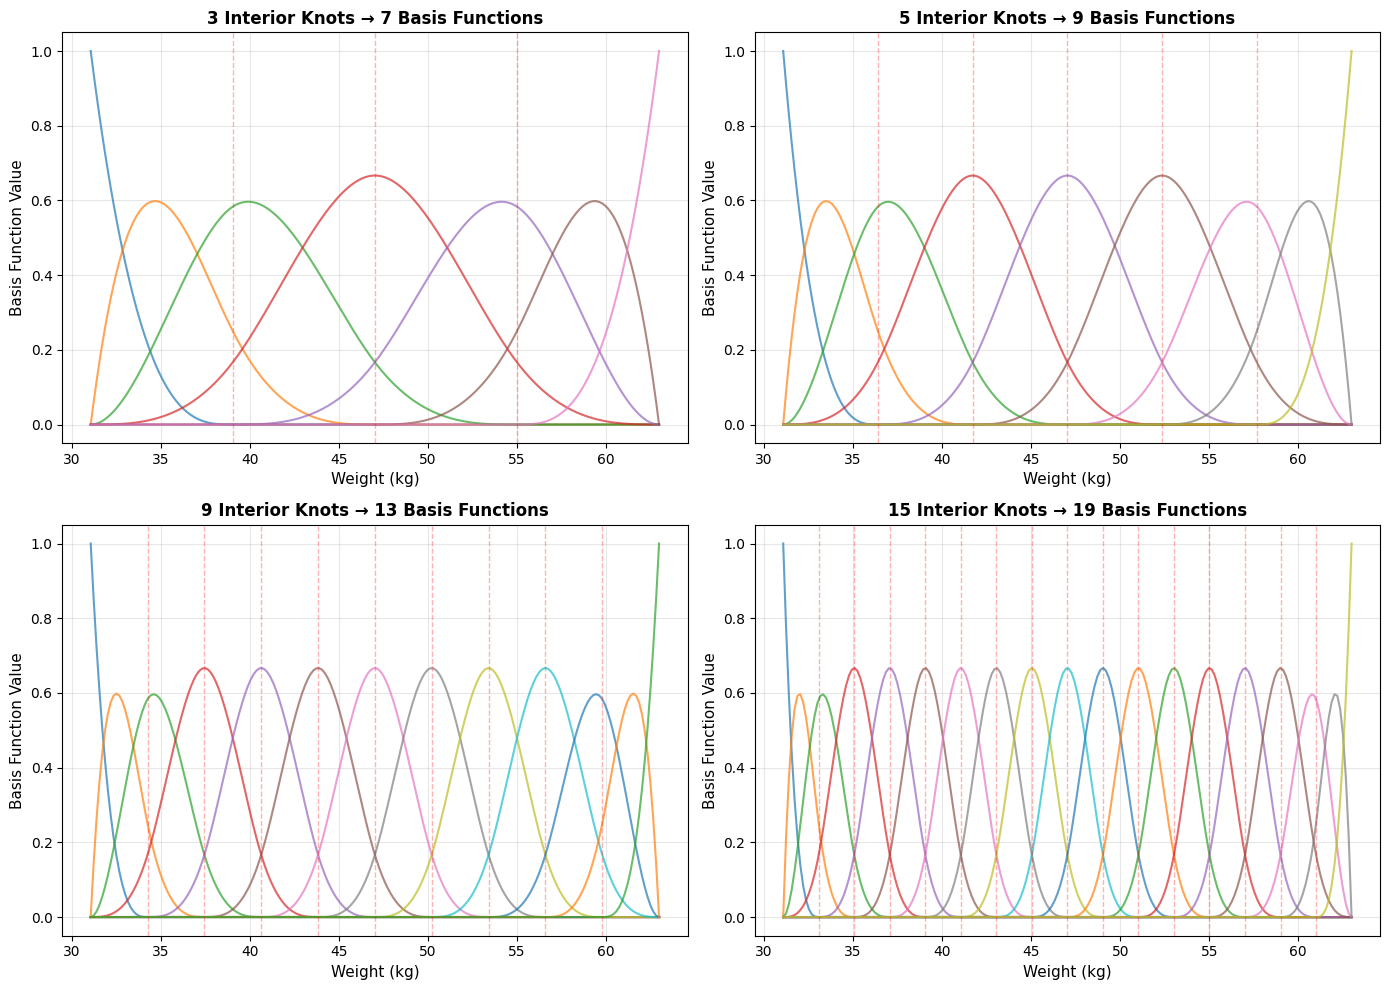

Key Observations:
• Each basis function is a smooth 'bump' with local support
• Red dashed lines = interior knots (where basis functions connect)
• More knots → more basis functions → more flexibility
• Number of basis functions = num_interior_knots + degree + 1
• For degree=3: num_basis = num_knots + 4


In [4]:
# Create basis functions for visualization
weight_seq = np.linspace(weight.min(), weight.max(), 200)

# Try different numbers of knots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

knot_counts = [3, 5, 9, 15]

for idx, num_knots in enumerate(knot_counts):
    ax = axes[idx]
    
    # Create basis
    B, interior_knots = create_bspline_basis(weight_seq, num_knots=num_knots, degree=3)
    
    # Plot each basis function
    for i in range(B.shape[1]):
        ax.plot(weight_seq, B[:, i], linewidth=1.5, alpha=0.7)
    
    # Mark knots
    for knot in interior_knots:
        ax.axvline(knot, color='red', linestyle='--', alpha=0.3, linewidth=1)
    
    ax.set_xlabel('Weight (kg)', fontsize=11)
    ax.set_ylabel('Basis Function Value', fontsize=11)
    ax.set_title(f'{num_knots} Interior Knots → {B.shape[1]} Basis Functions', 
                 fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Key Observations:")
print("• Each basis function is a smooth 'bump' with local support")
print("• Red dashed lines = interior knots (where basis functions connect)")
print("• More knots → more basis functions → more flexibility")
print("• Number of basis functions = num_interior_knots + degree + 1")
print("• For degree=3: num_basis = num_knots + 4")

### Understanding the Math

Our spline model is:

$$\mu_i = \alpha + \sum_{j=1}^{K} w_j \cdot B_j(x_i)$$

Where:
- $\mu_i$ = predicted height for observation i
- $\alpha$ = intercept
- $w_j$ = weight for basis function j (these are our parameters!)
- $B_j(x_i)$ = value of basis function j at weight $x_i$
- $K$ = number of basis functions

**Key insight:** This is still a **linear model** in the parameters (α, w₁, w₂, ..., wₖ), just with fancy predictors!

---

## Step 3: Fit Spline Models

Let's fit spline models with different numbers of knots.

In [5]:
def fit_spline_model(weight, height, num_knots=5, degree=3):
    """
    Fit B-spline model using quap.
    
    Model:
    height ~ Normal(mu, sigma)
    mu = alpha + sum(w_j * B_j(weight))
    
    Priors:
    alpha ~ Normal(178, 20)
    w_j ~ Normal(0, 10) for all j
    sigma ~ Exponential(1) [via log-normal]
    """
    n = len(height)
    
    # Create B-spline basis
    B, interior_knots = create_bspline_basis(weight, num_knots=num_knots, degree=degree)
    num_basis = B.shape[1]
    
    # Initial parameter guesses
    initial_alpha = height.mean()
    initial_weights = np.zeros(num_basis)  # Start at zero
    initial_log_sigma = np.log(height.std())
    initial_params = np.concatenate([[initial_alpha], initial_weights, [initial_log_sigma]])
    
    def neg_log_posterior(params):
        alpha = params[0]
        weights = params[1:num_basis+1]
        log_sigma = params[num_basis+1]
        sigma = np.exp(log_sigma)
        
        # Linear predictor: α + Σ w_j * B_j(x)
        mu = alpha + B @ weights
        
        # Likelihood: height ~ Normal(mu, sigma)
        log_lik = np.sum(stats.norm.logpdf(height, loc=mu, scale=sigma))
        
        # Priors
        log_prior_alpha = stats.norm.logpdf(alpha, loc=178, scale=20)
        log_prior_weights = np.sum(stats.norm.logpdf(weights, loc=0, scale=10))
        log_prior_log_sigma = stats.norm.logpdf(log_sigma, loc=np.log(10), scale=1)
        
        # Jacobian for log(sigma)
        jacobian = log_sigma
        
        log_posterior = log_lik + log_prior_alpha + log_prior_weights + log_prior_log_sigma + jacobian
        
        return -log_posterior
    
    # Parameter names
    param_names = ['alpha'] + [f'w{i}' for i in range(1, num_basis+1)] + ['log_sigma']
    
    # Fit with quap
    fit = quap(neg_log_posterior, initial_params=initial_params, param_names=param_names)
    
    # Store basis matrix and knots for later use
    fit.B = B
    fit.interior_knots = interior_knots
    fit.num_basis = num_basis
    fit.degree = degree
    
    return fit

print("✓ Spline model fitting function defined")

✓ Spline model fitting function defined


In [ ]:
# Fit models with different numbers of knots
print("Fitting B-spline models...")
print("="*60)

spline_models = {}
knot_options = [3, 5, 9, 15]

for num_knots in knot_options:
    print(f"\n{num_knots} interior knots...", end=" ")
    fit = fit_spline_model(weight, height, num_knots=num_knots, degree=3)
    spline_models[num_knots] = fit
    print("✓")
    
    # Show summary
    coef_estimates = fit.coef()
    print(f"  Number of basis functions: {fit.num_basis}")
    print(f"  α = {coef_estimates['alpha']:.2f}")
    print(f"  σ = {np.exp(coef_estimates['log_sigma']):.2f}")
    
    # Extract weight values
    weight_values = np.array([coef_estimates[f'w{i}'] for i in range(1, fit.num_basis+1)])
    print(f"  Weight range: [{weight_values.min():.2f}, {weight_values.max():.2f}]")

print("\n" + "="*60)
print("All spline models fitted successfully!")

---

## Step 4: Visualize Spline Fits

Let's see how different numbers of knots affect the fit.

In [ ]:
def predict_spline(fit, weight_new):
    """
    Generate predictions from fitted spline model.
    
    Parameters:
    -----------
    fit : QuapResult
        Fitted spline model
    weight_new : array
        New weight values to predict at
    
    Returns:
    --------
    mu_mean, mu_lower, mu_upper : arrays
        Mean and 89% interval for predictions
    """
    # Create basis matrix for new data
    B_new, _ = create_bspline_basis(weight_new, interior_knots=fit.interior_knots, degree=fit.degree)
    
    # Sample from posterior
    samples = fit.sample(n=1000, seed=42)
    alpha_samples = samples['alpha'].values
    weight_samples = np.column_stack([samples[f'w{i}'].values for i in range(1, fit.num_basis+1)])
    
    # Predictions: α + B·w
    mu_samples = alpha_samples[:, None] + (weight_samples @ B_new.T)
    
    # Summary statistics
    mu_mean = mu_samples.mean(axis=0)
    mu_lower = np.percentile(mu_samples, 5.5, axis=0)
    mu_upper = np.percentile(mu_samples, 94.5, axis=0)
    
    return mu_mean, mu_lower, mu_upper

print("✓ Spline prediction function defined")

In [ ]:
# Generate predictions
weight_seq = np.linspace(weight.min(), weight.max(), 200)

# Plot all spline fits
fig, axes = plt.subplots(2, 2, figsize=(16, 11))
axes = axes.flatten()

colors = ['blue', 'green', 'red', 'purple']

for idx, num_knots in enumerate(knot_options):
    ax = axes[idx]
    fit = spline_models[num_knots]
    
    # Scatter plot
    ax.scatter(weight, height, alpha=0.3, s=20, color='gray', label='Data')
    
    # Get predictions
    mu_mean, mu_lower, mu_upper = predict_spline(fit, weight_seq)
    
    # Plot mean line
    ax.plot(weight_seq, mu_mean, color=colors[idx], linewidth=2.5, 
            label=f'{num_knots} knots')
    
    # Plot uncertainty interval
    ax.fill_between(weight_seq, mu_lower, mu_upper, 
                    color=colors[idx], alpha=0.2)
    
    # Mark knots
    for knot in fit.interior_knots:
        ax.axvline(knot, color='red', linestyle='--', alpha=0.2, linewidth=1)
    
    # Labels
    ax.set_xlabel('Weight (kg)', fontsize=11)
    ax.set_ylabel('Height (cm)', fontsize=11)
    ax.set_title(f'B-spline with {num_knots} Interior Knots ({fit.num_basis} basis functions)', 
                 fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Observations:")
print("• 3 knots: Smooth, captures general trend")
print("• 5 knots: Good balance of smoothness and flexibility")
print("• 9 knots: More flexible, follows data more closely")
print("• 15 knots: Very flexible, potential overfitting?")
print("\nRed dashed lines show where knots are placed (where curve can 'bend')")

### Comparison: All Spline Models Together

In [ ]:
# All spline models on one plot
plt.figure(figsize=(12, 7))

# Scatter plot
plt.scatter(weight, height, alpha=0.3, s=30, color='gray', label='Data', zorder=1)

# Plot each spline
for idx, num_knots in enumerate(knot_options):
    mu_mean, _, _ = predict_spline(spline_models[num_knots], weight_seq)
    plt.plot(weight_seq, mu_mean, linewidth=2.5, label=f'{num_knots} knots', 
             color=colors[idx], zorder=2)

plt.xlabel('Weight (kg)', fontsize=12)
plt.ylabel('Height (cm)', fontsize=12)
plt.title('B-spline Regression: Comparison of Different Knot Numbers', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

print("Key Observations:")
print("• All spline models produce similar overall fits")
print("• More knots = more flexibility (can capture finer details)")
print("• But all stay reasonable - no wild oscillations like high-degree polynomials!")
print("• Splines are more stable than polynomials")

---

## Step 5: Splines vs Polynomials

Let's directly compare splines with polynomial regression.

In [ ]:
# Load polynomial model for comparison
# We'll fit a degree-4 polynomial for comparison
def fit_polynomial_model(weight, height, degree):
    """Simple polynomial model for comparison."""
    # Standardize
    weight_mean = weight.mean()
    weight_sd = weight.std()
    weight_std = (weight - weight_mean) / weight_sd
    
    # Create polynomial features
    X = np.column_stack([weight_std**i for i in range(1, degree + 1)])
    
    initial_alpha = height.mean()
    initial_betas = np.zeros(degree)
    initial_log_sigma = np.log(height.std())
    initial_params = np.concatenate([[initial_alpha], initial_betas, [initial_log_sigma]])
    
    def neg_log_posterior(params):
        alpha = params[0]
        betas = params[1:degree+1]
        log_sigma = params[degree+1]
        sigma = np.exp(log_sigma)
        
        mu = alpha + X @ betas
        
        log_lik = np.sum(stats.norm.logpdf(height, loc=mu, scale=sigma))
        log_prior_alpha = stats.norm.logpdf(alpha, loc=178, scale=20)
        log_prior_betas = np.sum(stats.norm.logpdf(betas, loc=0, scale=10))
        log_prior_log_sigma = stats.norm.logpdf(log_sigma, loc=np.log(10), scale=1)
        jacobian = log_sigma
        
        log_posterior = log_lik + log_prior_alpha + log_prior_betas + log_prior_log_sigma + jacobian
        return -log_posterior
    
    param_names = ['alpha'] + [f'beta{i}' for i in range(1, degree+1)] + ['log_sigma']
    fit = quap(neg_log_posterior, initial_params=initial_params, param_names=param_names)
    
    fit.weight_mean = weight_mean
    fit.weight_sd = weight_sd
    fit.degree = degree
    
    return fit

def predict_polynomial(fit, weight_new):
    """Predictions from polynomial model."""
    weight_std_new = (weight_new - fit.weight_mean) / fit.weight_sd
    X_new = np.column_stack([weight_std_new**i for i in range(1, fit.degree + 1)])
    
    samples = fit.sample(n=1000, seed=42)
    alpha_samples = samples['alpha'].values
    beta_samples = np.column_stack([samples[f'beta{i}'].values for i in range(1, fit.degree+1)])
    
    mu_samples = alpha_samples[:, None] + beta_samples @ X_new.T
    
    mu_mean = mu_samples.mean(axis=0)
    mu_lower = np.percentile(mu_samples, 5.5, axis=0)
    mu_upper = np.percentile(mu_samples, 94.5, axis=0)
    
    return mu_mean, mu_lower, mu_upper

# Fit polynomial model
print("Fitting polynomial model (degree 4) for comparison...")
poly_fit = fit_polynomial_model(weight, height, degree=4)
print("✓ Polynomial model fitted")

In [ ]:
# Compare spline vs polynomial
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Within data range
ax = axes[0]
weight_plot = np.linspace(weight.min(), weight.max(), 200)

ax.scatter(weight, height, alpha=0.3, s=20, color='gray', label='Data')

# Spline (5 knots)
mu_spline, mu_spline_lower, mu_spline_upper = predict_spline(spline_models[5], weight_plot)
ax.plot(weight_plot, mu_spline, color='blue', linewidth=2.5, label='Spline (5 knots)')
ax.fill_between(weight_plot, mu_spline_lower, mu_spline_upper, color='blue', alpha=0.2)

# Polynomial
mu_poly, mu_poly_lower, mu_poly_upper = predict_polynomial(poly_fit, weight_plot)
ax.plot(weight_plot, mu_poly, color='red', linewidth=2.5, label='Polynomial (degree 4)', linestyle='--')
ax.fill_between(weight_plot, mu_poly_lower, mu_poly_upper, color='red', alpha=0.2)

ax.set_xlabel('Weight (kg)', fontsize=12)
ax.set_ylabel('Height (cm)', fontsize=12)
ax.set_title('Within Data Range', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Right: With extrapolation
ax = axes[1]
weight_extrap = np.linspace(weight.min() - 5, weight.max() + 5, 300)

# Mark data range
ax.axvspan(weight.min(), weight.max(), alpha=0.1, color='green', label='Data range')

ax.scatter(weight, height, alpha=0.5, s=30, color='black', label='Data', zorder=5)

# Spline
mu_spline_ext, _, _ = predict_spline(spline_models[5], weight_extrap)
ax.plot(weight_extrap, mu_spline_ext, color='blue', linewidth=2.5, label='Spline (5 knots)')

# Polynomial
mu_poly_ext, _, _ = predict_polynomial(poly_fit, weight_extrap)
ax.plot(weight_extrap, mu_poly_ext, color='red', linewidth=2.5, label='Polynomial (degree 4)', linestyle='--')

ax.set_xlabel('Weight (kg)', fontsize=12)
ax.set_ylabel('Height (cm)', fontsize=12)
ax.set_title('With Extrapolation (Outside Data)', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim(120, 200)

plt.tight_layout()
plt.show()

print("Key Insights:")
print("• Within data range: Both perform similarly")
print("• Outside data range: Polynomial curves away dramatically")
print("• Spline extrapolation is more linear (more reasonable)")
print("• Splines have better 'edge behavior' than polynomials")

---

## Step 6: Understanding Spline Weights

Let's visualize how the weights (wᵢ) combine with basis functions to create the final curve.

In [ ]:
# Use the 5-knot model
fit = spline_models[5]
coefs = fit.coef()

# Get weights
alpha = coefs['alpha']
weights = np.array([coefs[f'w{i}'] for i in range(1, fit.num_basis + 1)])

# Create basis for plotting
weight_plot = np.linspace(weight.min(), weight.max(), 200)
B_plot, _ = create_bspline_basis(weight_plot, interior_knots=fit.interior_knots, degree=3)

# Calculate components
components = B_plot * weights  # Each column is w_j * B_j(x)
final_curve = alpha + components.sum(axis=1)  # α + Σ w_j * B_j(x)

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Top: Weighted basis functions
ax = axes[0]
for i in range(fit.num_basis):
    ax.plot(weight_plot, components[:, i], linewidth=1.5, alpha=0.7, 
            label=f'w{i+1}·B{i+1} (w={weights[i]:.2f})')

ax.axhline(0, color='black', linestyle='-', linewidth=0.8)
ax.set_xlabel('Weight (kg)', fontsize=11)
ax.set_ylabel('Weighted Basis Function Value', fontsize=11)
ax.set_title('Individual Weighted Basis Functions: wⱼ·Bⱼ(x)', fontsize=12, fontweight='bold')
ax.legend(fontsize=8, ncol=3)
ax.grid(True, alpha=0.3)

# Bottom: Sum to create final curve
ax = axes[1]
ax.scatter(weight, height, alpha=0.3, s=20, color='gray', label='Data')
ax.axhline(alpha, color='orange', linestyle='--', linewidth=2, 
           label=f'Intercept α = {alpha:.1f}')
ax.plot(weight_plot, final_curve, color='blue', linewidth=3, 
        label='Final: α + Σwⱼ·Bⱼ(x)')

ax.set_xlabel('Weight (kg)', fontsize=11)
ax.set_ylabel('Height (cm)', fontsize=11)
ax.set_title('Final Spline Curve: Sum of All Components', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("How it works:")
print(f"1. Start with intercept: α = {alpha:.2f}")
print(f"2. Add {fit.num_basis} weighted basis functions")
print("3. Each basis function contributes locally (bump-shaped)")
print("4. Weights control how much each basis function contributes")
print("5. Sum everything to get the final smooth curve")

---

## Summary

### What We Learned

1. **Splines are piecewise polynomials**
   - Divide x-axis into regions using knots
   - Low-degree polynomials in each region
   - Smooth connections at knots

2. **B-splines use basis functions**
   - Each basis function Bⱼ(x) is a smooth "bump"
   - Local support (non-zero only in small region)
   - Final curve: f(x) = α + Σ wⱼ·Bⱼ(x)
   - We estimate weights wⱼ using Bayesian inference

3. **Knot placement matters**
   - More knots → more flexibility
   - Fewer knots → smoother fit
   - Common choice: Quantiles of data
   - Typically use 3-15 knots

4. **Advantages over polynomials**
   - **Local influence**: Changes in one region don't affect distant regions
   - **Better extrapolation**: More stable outside data range
   - **Numerical stability**: No extreme values like x⁶
   - **Flexible but controlled**: Can be complex without overfitting

5. **Still a linear model!**
   - Linear in parameters (α, w₁, w₂, ..., wₖ)
   - Just using fancy predictors (basis functions)
   - All standard Bayesian inference tools apply

### When to Use Splines

✓ When relationship is clearly non-linear  
✓ When you want smooth, flexible curves  
✓ When extrapolation is important  
✓ When you need interpretable local behavior  
✓ As a better alternative to high-degree polynomials  

### Choosing Number of Knots

- **Start with ~5 knots** for most applications
- Increase if fit is too rigid
- Decrease if overfitting
- Use cross-validation or information criteria (WAIC, PSIS) for formal comparison

### What's Next?

- **Multiple predictors** - Splines with multiple variables
- **Interactions** - When effects depend on combinations
- **Generalized additive models (GAMs)** - Flexible framework using splines
- **Model comparison** - Formal methods to choose complexity

---

**Remember:** Splines provide a principled way to fit smooth, flexible curves without the dangers of high-degree polynomials. They're one of the most useful tools in modern regression modeling!